# Running and Plotting LightCones

This tutorial follows on from the coeval cube tutorial, and provides an introduction to creating lightcones with ``21CMMC``. If you are new to ``21CMMC`` you should go through the coeval cube tutorial first.

There are two ways of creating lightcones in ``21CMMC``: manual and automatic. The manual way involves evolving a coeval simulation through redshift and saving slices of it into a lightcone array. The advantage of this method is that one can precisely choose the redshift nodes to simulate and decide on interpolation methods. However, in this tutorial, we will focus on the single function that is included to do this for you: ``run_lightcone``. 

The function takes a few different arguments, most of which will be familiar to you if you've gone through the coeval tutorial. All simulation parameters can be passed (i.e. ``user_params``, ``cosmo_params``, ``flag_options`` and ``astro_params``). As an alternative to the first two, an ``InitialConditions`` and/or ``PerturbField`` box can be passed. 

Furthermore, the evolution can be managed with the ``z_step_factor`` and ``z_heat_max`` arguments. 

Finally, the final *minimum* redshift of the lightcone is set by the ``redshift`` argument, and the maximum redshift of the lightcone is defined by the ``max_redshift`` argument (note that this is not the maximum redshift evaluated, which is controlled by ``z_heat_max``, merely the maximum saved into the returned lightcone). 

Let's see what it does. We won't use the spin temperature, just to get a simple toy model:

In [3]:
import py21cmmc as p21c
#from py21cmmc import plotting

print(f"21CMMC version is {p21c.__version__}")

21CMMC version is 1.0.0dev


In [8]:
redshift_table=[5,7,9,11,13,15]
#init, perturb, ionize, brightness_temp = p21c.run_coeval( redshift=redshift_table,
#                          cosmo_params=p21c.CosmoParams(hlittle=0.7),
#                          user_params=p21c.UserParams(HII_DIM=100))

#fig, ax = plt.subplots(1,3, figsize=(12,4))
#for i in range(3):
#    plotting.coeval_sliceplot(ionize[i],ax=ax[i], fig=fig);
#    plt.title("z = %s"%[8,9,10][i])
#plt.tight_layout()
core = mcmc.CoreLightConeModule( # All core modules are prefixed by Core* and end with *Module
    redshift = 7.0,              # Lower redshift of the lightcone
    max_redshift = 9.0,          # Approximate maximum redshift of the lightcone (will be exceeded).
    user_params = dict(       
        HII_DIM = 50,         
        BOX_LEN = 125.0
    ),
    z_step_factor=1.04,          # How large the steps between evaluated redshifts are (log).
    z_heat_max=18.0,             # Completely ineffective since no spin temp or inhomogeneous recombinations.
    regenerate=False          
)
xH_z = []
for xH_z_tmp in ionize:
    xH_z.append(1-xH_z_tmp.global_xH)
    print(xH_z)
print(redshift_table[1])
print(xH_z[0])

NameError: name 'ionize' is not defined

In [11]:
lightcone = p21c.run_lightcone(
    redshift = 8.0,
    max_redshift = 14.0,
    #do_spin_temp = False,
    user_params = {"HII_DIM":150, "BOX_LEN": 600}
)

In [4]:
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy import Class
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
import math

In [ ]:
plotting.lightcone_sliceplot(lightcone);

In [ ]:
#xH_z
ax1 = plt.subplot(111)
ax1.semilogx(redshift_table,xH_z,'r',label=r'$x_e$')
plt.show()


In [ ]:
common_settings = {'output' : 'tCl',
                   # LambdaCDM parameters
                   'h':0.67556,
                   'omega_b':0.022032,
                   'omega_cdm':0.12038,
                   'A_s':2.215e-9,
                   'n_s':0.9619,
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
                   'YHe':0.246,
                   'reio_parametrization':'reio_inter',
                   'reio_inter_num':9,
                   #'reio_inter_z':'0,  3, 4,   8,   9,  10,  11, 12',
                   #'reio_inter_xe':'-2, -2, -1,  -1, 0.9, 0.5, 0.1,  0',
                   'reio_inter_z':'%.2f,%.2f,%.2f,%.2f,%.2f,%.2f,%.2f,%.2f,%.2f'%(0,3,redshift_table[0],redshift_table[1],redshift_table[2],redshift_table[3],redshift_table[4],redshift_table[5],20),
                   'reio_inter_xe':'%.2f,%.2f,%.2f,%.2f,%.2f,%.2f,%.2f,%.2f,%.2f'%(-2,-1,xH_z[0],xH_z[1],xH_z[2],xH_z[3],xH_z[4],xH_z[5],0),
                   'thermodynamics_verbose':1
                   }  
##############
#    
# call CLASS
#
###############
M = Class()
M.set(common_settings)
M.compute()
derived = M.get_current_derived_parameters(['tau_rec','conformal_age'])
thermo = M.get_thermodynamics()
thermo.items()

xe = thermo['x_e']
z = thermo['z']
ax1 = plt.subplot(111)
ax1.semilogx(z,xe,'r',label=r'$x_e$')
plt.show()

[ 0.          3.          4.          8.          8.17999983  8.36359965
  8.55087146  8.74188871  8.9367263   9.13546064  9.33816966  9.54493285
  9.75583131  9.97094773 10.19036647 10.41417359 10.64245684 10.87530576
 11.11281165 11.35506765 11.60216877 11.8542119  12.11129589 12.37352156
 12.64099174 12.91381131 13.19208727 13.47592875 13.76544705 14.06075571
 15.        ]


<IPython.core.display.Javascript object>


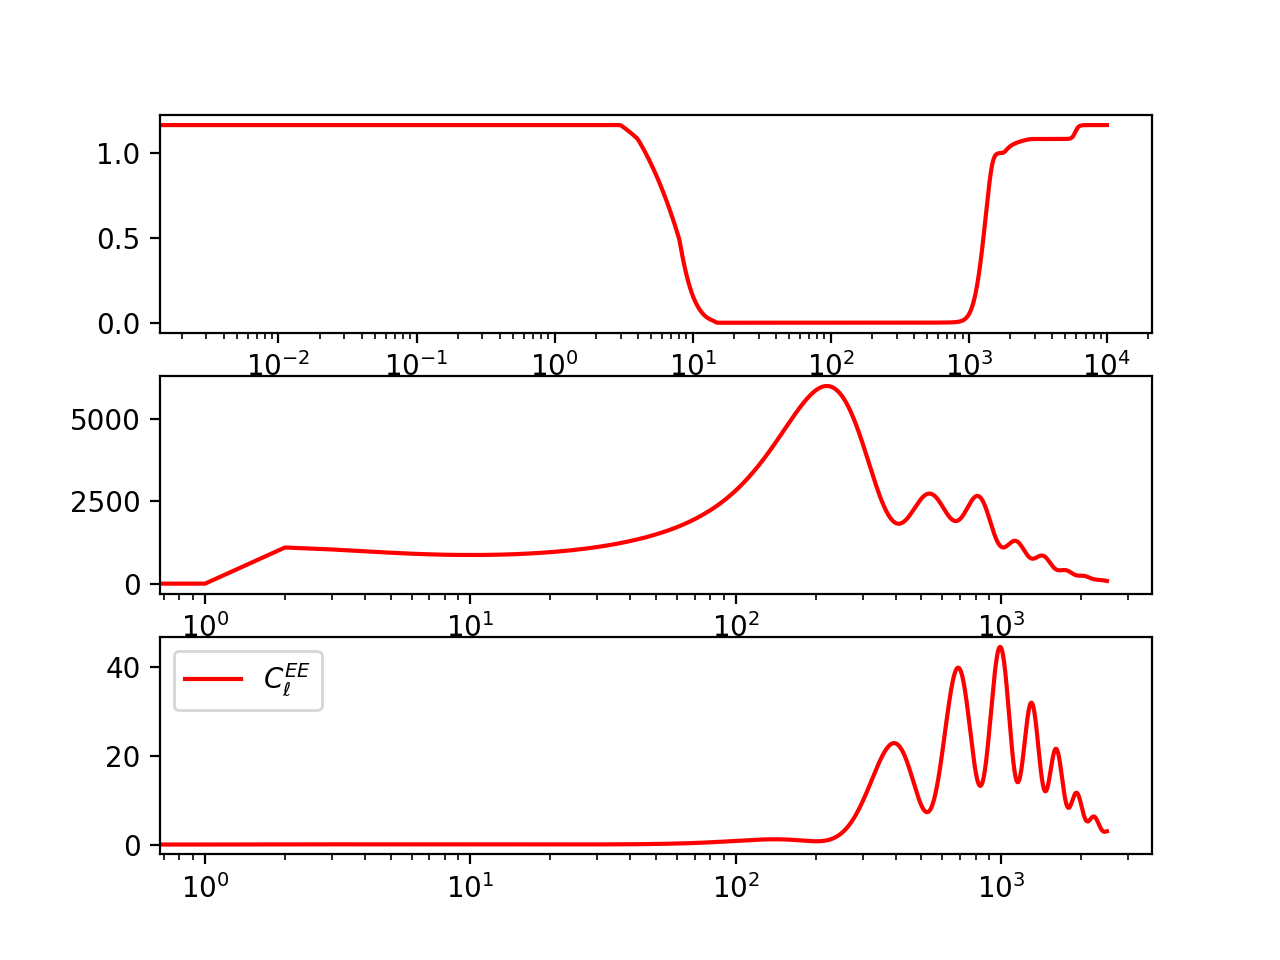

In [12]:
    # Simple linear extrapolation of the redshift range provided by the user, to be able to estimate the optical depth
n_z_interp = 15

# Minimum of extrapolation is chosen to 5.9, to correspond to the McGreer et al. prior on the IGM neutral fraction.
# The maximum is chosed to be z = 18., which is arbitrary.
z_extrap_min = 8
z_extrap_max = 14.0

##option for class
z_class_min = 0
z_HeI = 4
z_HeII = 3
z_class_max = z_extrap_max
z_xe_0 = z_class_max+1

##output option for class
thermodynamics_verbose = 1

#lightcone = ctx.get('lightcone')

##cosmological parameters for class
h = 0.67556
omega_b = 0.022032
omega_cdm = 0.12038
A_s = 2.215e-9
n_s = 0.9619
# Extract relevant info from the context.


xHI = lightcone.global_xHI
redshifts = lightcone.node_redshifts



# Order the redshifts in increasing order
redshifts, xHI = np.sort(np.array([redshifts, xHI]))

xe = 1-xHI
# The linear interpolation/extrapolation function, taking as input the redshift supplied by the user and
# the corresponding neutral fractions recovered for the specific EoR parameter set
# neutral_frac_func = InterpolatedUnivariateSpline(redshifts, 1-xHI, k=1)
#
# # Perform extrapolation
# z_extrap = np.linspace(self.z_extrap_min, self.z_extrap_max, self.n_z_interp)
# xHI = neutral_frac_func(z_extrap)
# np.clip(xHI, 0, 1, xHI)

xe = np.concatenate(([-2,-2,-1], xe,[0]))
redshift_class =np.concatenate(([0,z_HeII,z_HeI],redshifts,[z_xe_0]))
print((redshift_class))

common_settings = {'output' : 'tCl, pCl, lCl',
           'lensing':'yes',
           # LambdaCDM parameters
           'h':h,
           'omega_b':omega_b,
           'omega_cdm':omega_cdm,
           'A_s':A_s,
           'n_s':n_s,
           # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
           'reio_parametrization':'reio_inter',
           'reio_inter_num':len(xe),
           'reio_inter_z':','.join([str(x) for x in redshift_class]), #str(redshift_class),
           'reio_inter_xe':','.join([str(x) for x in xe]),
           'thermodynamics_verbose':thermodynamics_verbose
           }
##############
#
# call CLASS
#
###############
cosmo = Class()
cosmo.set(common_settings)
cosmo.compute()
derived = cosmo.get_current_derived_parameters(['tau_rec','conformal_age'])
thermo = cosmo.get_thermodynamics()
thermo.items()

xe = thermo['x_e']
z = thermo['z']
ax1 = plt.subplot(311)
ax1.semilogx(z,xe,'r',label=r'$x_e$')
l_max = -1
cl = cosmo.lensed_cl(int(l_max))

        # convert dimensionless C_l's to C_l in muK**2
T = cosmo.T_cmb()

ax2 = plt.subplot(312)
ax2.semilogx(cl['ell'],cl['ell']*(cl['ell']+1)*cl['tt']*(T*1.e6)**2/2/np.pi,'r',label=r'$C_{\ell}^{TT}$')
ax3 = plt.subplot(313)
ax3.semilogx(cl['ell'],cl['ell']*(cl['ell']+1)*cl['ee']*(T*1.e6)**2/2/np.pi,'r',label=r'$C_{\ell}^{EE}$')
plt.legend()
plt.show()

Simple!